In [ ]:
#Import packages
import cv2
import skimage

In [ ]:
!pip install mahotas

In [ ]:
#Mount drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/8Feb_new')


In [ ]:
from ELM import *
from features import *
from ELM_segmentation import *

In [ ]:
#Read data
image_dir = '/content/drive/MyDrive/8Feb_new/pots/images/store'
label_dir = '/content/drive/MyDrive/8Feb_new/pots/labels/store'

In [ ]:
image_list, label_list = read_data(image_dir, label_dir)

[INFO] Reading image data.
[INFO] Creating training dataset on 2 image(s).
[INFO] Computing local binary pattern features.
[INFO] Computing local binary pattern features.
[INFO] Feature vector size: (1600, 4)


In [ ]:
len(image_list)

2

In [ ]:
X = []
y = []

for i, img in enumerate(image_list):
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  lbp_radius = 24 # local binary pattern neighbourhood
  h_neigh = 11 # haralick neighbourhood
  num_examples = 1000 # number of examples per image to use for training model
  lbp_points = lbp_radius*8
  h_ind = int((h_neigh - 1)/ 2)

  feature_img = np.zeros((img.shape[0],img.shape[1],4))
  feature_img[:,:,:3] = img/255.0
  img = None
  feature_img[:,:,3] = create_binary_pattern(img_gray, lbp_points, lbp_radius)
  feature_img = feature_img[h_ind:-h_ind, h_ind:-h_ind]
  features = feature_img.reshape(feature_img.shape[0]*feature_img.shape[1], feature_img.shape[2])

  #subsampling to get random 1000 pixels of the image
  ss_idx = subsample_idx(0, features.shape[0], num_examples)
  features = features[ss_idx]

  label = label_list[i]
  label = label[h_ind:-h_ind, h_ind:-h_ind]
  labels = label.reshape(label.shape[0]*label.shape[1], 1)
  labels = labels[ss_idx]

  X.append(features)
  y.append(labels)

[INFO] Computing local binary pattern features.
[INFO] Computing local binary pattern features.


In [ ]:
y.shape

(2000,)

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = MinMaxScaler((-1.0,1.0))
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
ELM_obj = ELM(X_train.shape[1],500)
ELM_obj.fit(X_train,y_train/255.0,1e-2)
predY = ELM_obj.predict(X_train)
predTY = ELM_obj.predict(X_test)
predY[predY<0.5]=0
predY[predY>=0.5]=1
predTY[predTY<0.5]=0
predTY[predTY>=0.5]=1

In [ ]:
TrainAccuracy = np.mean(y_train/255 == predY)
TestAccuracy = np.mean(y_test/255 == predTY)
print('Train Accuracy is {:}\nTest Accuracy is {:}'.format(np.round(TrainAccuracy*100,4),np.round(TestAccuracy*100,4)))

Train Accuracy is 81.1875
Test Accuracy is 80.75


In [ ]:
img_test = cv2.imread('/content/drive/MyDrive/8Feb_new/pots_block_2_28.jpg', 1)
img_gray = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
features, labels, feature_img =create_features(img_test, img_gray, label=None, train=False)
seg_size = int(math.sqrt(features.shape[0]))
seg_val = ELM_obj.predict(scaler.transform(features))
seg_val[seg_val < 0.5] = 0
seg_val[seg_val >= 0.5] =1
seg_val = seg_val*255
seg_val = seg_val.astype(np.uint8)
seg_img = np.reshape(seg_val,(seg_size,seg_size))

[INFO] Computing local binary pattern features.


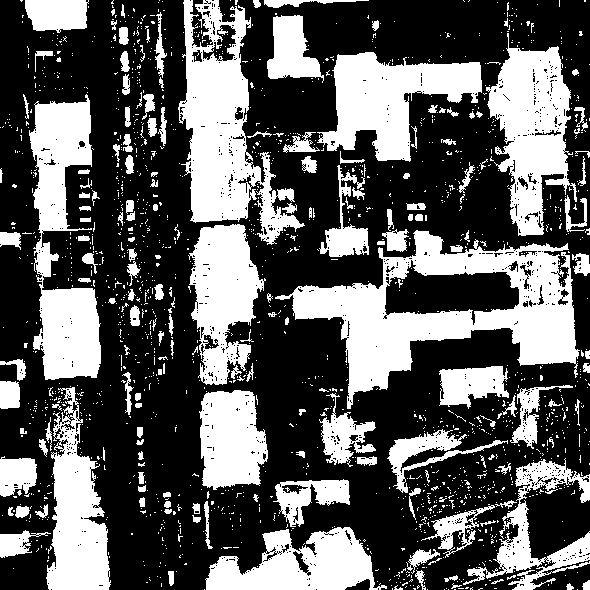

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(seg_img)